## Link between Groceries and Income 

For Ward, MSOA and LSOA

In [179]:
# Import useful libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy import stats
from sklearn import linear_model, model_selection

### Data Cleaning

In [180]:
# Load Data 

data_folder = './data/'

groceries_ward = pd.read_csv(data_folder + 'year_osward_grocery.csv')
groceries_msoa = pd.read_csv(data_folder + 'year_msoa_grocery.csv')
groceries_lsoa = pd.read_csv(data_folder + 'year_lsoa_grocery.csv')
income_ward = pd.read_csv(data_folder + 'modelled-household-income-estimates-wards.csv', encoding='latin1')
income_msoa = pd.read_csv(data_folder + 'modelled-household-income-estimates-msoa.csv', encoding='latin1')
income_lsoa = pd.read_csv(data_folder + 'modelled-household-income-estimates-lsoa.csv', encoding='latin1')


In [181]:
print(f'We have Shopping data for {len(groceries_ward)} Wards, {len(groceries_msoa)} MSOAs and {len(groceries_lsoa)} LSOAs')
print(f'We have Income data for {len(income_ward)} Wards, {len(income_msoa)} MSOAs and {len(income_lsoa)} LSOAs')


We have Shopping data for 638 Wards, 983 MSOAs and 4833 LSOAs
We have Income data for 625 Wards, 983 MSOAs and 4835 LSOAs


In [182]:
def clean_income_value(income):
    """ Transforms the string '£XX,XXX' into the corresponding integer value XXXXX, if an integer value is given returns it"""
    return int(income[1:].replace(',','')) if type(income) != int else income

In [183]:
# Clean the Dataframe so we can use the values 
years = ['01/02', '02/03', '03/04', '04/05', '05/06', '06/07', '07/08', '08/09', '09/10', '10/11', '11/12', '12/13']
for year in years :
    mean_column = 'Mean 20' + year
    median_column = 'Median 20' + year
    # MSOA
    income_msoa[mean_column] = income_msoa[mean_column].map(lambda i : clean_income_value(i) )
    income_msoa[median_column] = income_msoa[median_column].map(lambda i : clean_income_value(i))
    # LSOA
    income_lsoa[mean_column] = income_lsoa[mean_column].map(lambda i : clean_income_value(i) )
    income_lsoa[median_column] = income_lsoa[median_column].map(lambda i : clean_income_value(i))
    # Ward
    income_ward[mean_column] = income_ward[mean_column].map(lambda i : clean_income_value(i) )
    income_ward[median_column] = income_ward[median_column].map(lambda i : clean_income_value(i))

### Data visualization

<ipython-input-184-b9982dbe54d7>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0,0].set_xticklabels(labels=mean_columns, rotation=90)
<ipython-input-184-b9982dbe54d7>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0,1].set_xticklabels(labels=median_columns, rotation=90)
<ipython-input-184-b9982dbe54d7>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1,0].set_xticklabels(labels=mean_columns, rotation=90)
<ipython-input-184-b9982dbe54d7>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1,1].set_xticklabels(labels=median_columns, rotation=90)
<ipython-input-184-b9982dbe54d7>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2,0].set_xticklabels(labels=mean_columns, rotation=90)
<ipython-input-184-b9982dbe54d7>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2,1].se

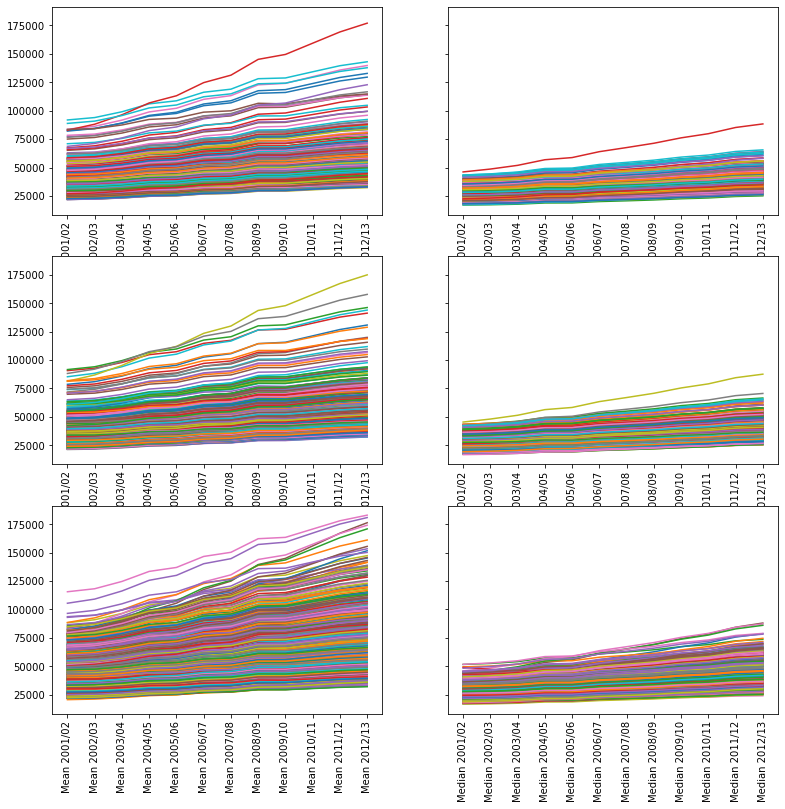

In [184]:
mean_columns = ['Mean 20' + year for year in years]
median_columns = ['Median 20' + year for year in years]

fig, axes = plt.subplots(3,2, figsize=(13,13), sharey=True)
ward_sample = np.random.choice(range(len(income_ward)), 625, replace=False)
msoa_sample = np.random.choice(range(len(income_msoa)), 983, replace=False)
lsoa_sample = np.random.choice(range(len(income_lsoa)), 4835, replace=False)

for i in ward_sample:
    axes[0,0].plot(pd.DataFrame(income_ward.iloc[i][mean_columns]))
    axes[0,0].set_xticklabels(labels=mean_columns, rotation=90)
    axes[0,1].plot(pd.DataFrame(income_ward.iloc[i][median_columns]))
    axes[0,1].set_xticklabels(labels=median_columns, rotation=90)
    
for i in msoa_sample:
    axes[1,0].plot(pd.DataFrame(income_msoa.iloc[i][mean_columns]))
    axes[1,0].set_xticklabels(labels=mean_columns, rotation=90)
    axes[1,1].plot(pd.DataFrame(income_msoa.iloc[i][median_columns]))
    axes[1,1].set_xticklabels(labels=median_columns, rotation=90)
    
for i in lsoa_sample:
    axes[2,0].plot(pd.DataFrame(income_lsoa.iloc[i][mean_columns]))
    axes[2,0].set_xticklabels(labels=mean_columns, rotation=90)
    axes[2,1].plot(pd.DataFrame(income_lsoa.iloc[i][median_columns]))
    axes[2,1].set_xticklabels(labels=median_columns, rotation=90)

So first we are interested in seeing how the Mean and Median income evolves between the years. 

As we can see on the graph above, there are some outliers but we can see that overall the Mean and Median outcome tend to go up ! 

We decide to use the revenue for year 2012/13 as it is the closest data we have to 2015. Note that since we see a tendency to going growing, we can assume that an overall increasing trend is to be exected. 

We could find a regressor to find an expected value for 2014/15 

### Correlation between Groceries propostions and Income

In [185]:
# We only keep data for features of interest
features_of_interest = ['Code', 'Mean 2012/13', 'Median 2012/13']

income_ward_12_13 = income_ward[features_of_interest]
income_msoa_12_13 = income_msoa[features_of_interest]
income_lsoa_12_13 = income_lsoa[features_of_interest]

# Join the Income Data on the corresponding Shopping Data 

groceries_income_ward = groceries_ward.join(income_ward_12_13.set_index('Code'),on='area_id',how='inner').rename(columns={'Mean 2012/13': 'mean_income', 'Median 2012/13': 'median_income'})
groceries_income_msoa = groceries_msoa.join(income_msoa_12_13.set_index('Code'),on='area_id',how='inner').rename(columns={'Mean 2012/13': 'mean_income', 'Median 2012/13': 'median_income'})
groceries_income_lsoa = groceries_lsoa.join(income_lsoa_12_13.set_index('Code'),on='area_id',how='inner').rename(columns={'Mean 2012/13': 'mean_income', 'Median 2012/13': 'median_income'})



In [186]:
for c in groceries_income_ward.columns:
    print(c)

area_id
weight
weight_perc2.5
weight_perc25
weight_perc50
weight_perc75
weight_perc97.5
weight_std
weight_ci95
volume
volume_perc2.5
volume_perc25
volume_perc50
volume_perc75
volume_perc97.5
volume_std
volume_ci95
fat
fat_perc2.5
fat_perc25
fat_perc50
fat_perc75
fat_perc97.5
fat_std
fat_ci95
saturate
saturate_perc2.5
saturate_perc25
saturate_perc50
saturate_perc75
saturate_perc97.5
saturate_std
saturate_ci95
salt
salt_perc2.5
salt_perc25
salt_perc50
salt_perc75
salt_perc97.5
salt_std
salt_ci95
sugar
sugar_perc2.5
sugar_perc25
sugar_perc50
sugar_perc75
sugar_perc97.5
sugar_std
sugar_ci95
protein
protein_perc2.5
protein_perc25
protein_perc50
protein_perc75
protein_perc97.5
protein_std
protein_ci95
carb
carb_perc2.5
carb_perc25
carb_perc50
carb_perc75
carb_perc97.5
carb_std
carb_ci95
fibre
fibre_perc2.5
fibre_perc25
fibre_perc50
fibre_perc75
fibre_perc97.5
fibre_std
fibre_ci95
alcohol
alcohol_perc2.5
alcohol_perc25
alcohol_perc50
alcohol_perc75
alcohol_perc97.5
alcohol_std
alcohol_ci95
en

In [187]:
categories_fraction = ['f_beer', 'f_dairy', 'f_eggs', 'f_fats_oils', 'f_fish', 'f_fruit_veg', 'f_grains', 'f_meat_red', 
                       'f_poultry', 'f_readymade', 'f_sauces', 'f_soft_drinks', 'f_spirits', 'f_sweets', 'f_tea_coffee', 
                       'f_water', 'f_wine']
nutrients_fraction = ['energy_fat', 'energy_saturate', 'energy_sugar', 'energy_protein', 'energy_carb', 'energy_fibre', 'energy_alcohol', 'energy_tot']
groceries_dfs = [('ward', groceries_income_ward), ('msoa', groceries_income_msoa), ('lsoa', groceries_income_lsoa)]

def compute_correlations_categories_incomes(df, income, categories=categories_fraction):
    r_values = []
    p_values = []
    category = []

    for cat in categories:
        correl, p_value = stats.spearmanr(df[cat],df[income])
        #print(f"- {cat} : {correl} with p-value {p_value}")
        r_values.append(correl)
        p_values.append(p_value)
        category.append(cat)


    correlation_df = pd.DataFrame({'Category' : category, 'R': r_values, 'p': p_values, 'statistically_significant' : [ p < 0.05 for p in p_values]})
    correlation_df
    
    return correlation_df

def compute_correlations_categories_incomes_list(dfs, income, categories=categories_fraction):
    correlation_df = pd.DataFrame({'Category' : categories})
    for name, df in dfs:
        r_values = []
        p_values = []

        for cat in categories:
            correl, p_value = stats.spearmanr(df[cat],df[income])
            #print(f"- {cat} : {correl} with p-value {p_value}")
            r_values.append(correl)
            p_values.append(p_value)

        correlation_df['R_'+name] = r_values
        correlation_df['p_'+name] = p_values
        correlation_df['stat_'+name] = [ p < 0.05 for p in p_values]
    
    return correlation_df

def compute_correlations_categories_incomes_grouped(dfs, income, categories=categories_fraction, category_name = 'category'):
    r_values = []
    p_values = []
    census = []
    for name, df in dfs:
        for cat in categories:
            correl, p_value = stats.spearmanr(df[cat],df[income])
            #print(f"- {cat} : {correl} with p-value {p_value}")
            r_values.append(correl)
            p_values.append(p_value)
            census.append(name)

    correlation_df = pd.DataFrame({category_name : categories * len(dfs), 'census': census, 'R': r_values, 'p': p_values, 'stat_sig' : [ p < 0.05 for p in p_values]})

    return correlation_df.groupby([category_name,'census']).sum()


In [188]:
# Computes the correlation between Mean Income in 2012/13 and the food categories ! 
compute_correlations_categories_incomes_grouped(dfs=groceries_dfs, income='mean_income')

R              p  stat_sig
category      census                                   
f_beer        lsoa    0.241147   6.712715e-65         1
              msoa    0.329865   2.209742e-26         1
              ward    0.401195   4.195477e-20         1
f_dairy       lsoa    0.091833   1.594078e-10         1
              msoa    0.132492   3.085086e-05         1
              ward    0.119722   8.443079e-03         1
f_eggs        lsoa    0.028132   5.050759e-02         0
              msoa    0.027963   3.811476e-01         0
              ward    0.013389   7.691430e-01         0
f_fats_oils   lsoa   -0.183435   7.721687e-38         1
              msoa   -0.215937   7.782019e-12         1
              ward   -0.252480   1.846039e-08         1
f_fish        lsoa    0.253897   5.632976e-72         1
              msoa    0.296938   1.845575e-21         1
              ward    0.290188   7.955804e-11         1
f_fruit_veg   lsoa    0.597351   0.000000e+00         1
              msoa    0.650042  4.106388e-119         1
              ward    0.679052   1.423276e-66         1
f_grains      lsoa   -0.457072  3.615007e-248         1
              msoa   -0.502994   3.682390e-64         1
              ward   -0.517392   2.008923e-34         1
f_meat_red    lsoa   -0.074594   2.084255e-07         1
              msoa   -0.072950   2.217616e-02         1
              ward   -0.095344   3.619338e-02         1
f_poultry     lsoa    0.000390   9.783816e-01         0
              msoa   -0.008226   7.967309e-01         0
              ward   -0.028251   5.356600e-01         0
f_readymade   lsoa   -0.037013   1.007233e-02         1
              msoa   -0.021158   5.075946e-01         0
              ward   -0.000089   9.984484e-01         0
f_sauces      lsoa   -0.000909   9.496522e-01         0
              msoa   -0.011878   7.099363e-01         0
              ward   -0.010733   8.139962e-01         0
f_soft_drinks lsoa   -0.612271   0.000000e+00         1
              msoa   -0.682148  1.581922e-135         1
              ward   -0.703869   1.838281e-73         1
f_spirits     lsoa   -0.300546  1.850425e-101         1
              msoa   -0.448386   8.681138e-50         1
              ward   -0.517000   2.296259e-34         1
f_sweets      lsoa   -0.447342  1.485453e-236         1
              msoa   -0.495276   5.735457e-62         1
              ward   -0.519211   1.076634e-34         1
f_tea_coffee  lsoa   -0.195203   1.030433e-42         1
              msoa   -0.282885   1.519790e-19         1
              ward   -0.306966   5.350043e-12         1
f_water       lsoa   -0.627915   0.000000e+00         1
              msoa   -0.733513  1.066356e-166         1
              ward   -0.763828   1.626275e-93         1
f_wine        lsoa    0.618267   0.000000e+00         1
              msoa    0.736352  1.240220e-168         1
              ward    0.764709   7.455158e-94         1

In [189]:
# Computes the correlation between Mean Income in 2012/13 and the energy from nutients  ! 
compute_correlations_categories_incomes_grouped(dfs=groceries_dfs, income='mean_income', categories=nutrients_fraction, category_name='nutrient')

R              p  stat_sig
nutrient        census                                   
energy_alcohol  lsoa    0.353950  1.241817e-142         1
                msoa    0.468979   6.633793e-55         1
                ward    0.483543   1.136708e-29         1
energy_carb     lsoa   -0.535164   0.000000e+00         1
                msoa   -0.581642   4.703541e-90         1
                ward   -0.615712   9.802861e-52         1
energy_fat      lsoa   -0.197629   9.281948e-44         1
                msoa   -0.296053   2.454642e-21         1
                ward   -0.322359   3.844112e-13         1
energy_fibre    lsoa    0.552091   0.000000e+00         1
                msoa    0.651744  6.216726e-120         1
                ward    0.662318   2.668236e-62         1
energy_protein  lsoa    0.280488   4.485710e-88         1
                msoa    0.344536   8.861380e-29         1
                ward    0.337472   2.493355e-14         1
energy_saturate lsoa   -0.086259   1.897177e-09         1
                msoa   -0.142765   7.008351e-06         1
                ward   -0.198821   1.071416e-05         1
energy_sugar    lsoa   -0.387718  3.805072e-173         1
                msoa   -0.424983   2.201584e-44         1
                ward   -0.425527   1.156509e-22         1
energy_tot      lsoa   -0.423320  1.875240e-209         1
                msoa   -0.501191   1.211114e-63         1
                ward   -0.543322   1.920735e-38         1

In [190]:
print(f"Correlations between categories proportions and income for MSOA")
compute_correlations_categories_incomes(groceries_income_msoa, 'mean_income', categories=categories_fraction)

Correlations between categories proportions and income for MSOA


,Category,R,p,statistically_significant
0,f_beer,0.329865,2.209742e-26,True
1,f_dairy,0.132492,3.085086e-05,True
2,f_eggs,0.027963,3.811476e-01,False
3,f_fats_oils,-0.215937,7.782019e-12,True
4,f_fish,0.296938,1.845575e-21,True
5,f_fruit_veg,0.650042,4.106388e-119,True
6,f_grains,-0.502994,3.682390e-64,True
7,f_meat_red,-0.072950,2.217616e-02,True
8,f_poultry,-0.008226,7.967309e-01,False
9,f_readymade,-0.021158,5.075946e-01,False


We have to analyse these results ! 

- Explain what the numbers mean 
- Explain that some correlations were expectables
- Explain the surprising correlations as well. 
- Reasons why water is negatively correlated with income ? ( Everybody drinks it, but maybe the tap water quality is worse in poorer areas, so ppl need to buy bottled water )
- Discuss the fact that some areas might have skewed data (very few people actually living there, which means that very few people actually do grocery shopping there ) 
- Maybe impact of other factors ? (minorities ... ) 


### Linear Regression
Regression : https://scikit-learn.org/stable/supervised_learning.html

Simple regression first and see the results, if logistic reg give good result nice OW try using more complex models. Check the overviews pages of SK-Learn. 

Check population density for MSOA/LSOA.

Could look at the litterature on rel purchase and income, look at the finidings in litterature. 

Compare our results and compare differences or so -> Might lead to some new analysis to confirm results. 

Look for paper on google scholar but it's a bit hard and only looks at the Paper's title.
Look at paper's citations in the paper and look at the ones in our fields. 

Also looked at the 'cited-by' field. 

So we will first try and fit a linear regressor to predict Mean and Median Income and see how well it performs. 
We keep 70% of our data for training. From the previous correlation studies, we decide to use as features only the columns for which the correlation is statistically significant. 

First we'll study the case for MSOA as it is the middle sized and we can witness the same phenomena for the three areas ! 

Hence we will use for training 
**f_beer, f_dairy, f_fats_oils, f_fish, f_fruit_veg, f_grains, f_meat_red, f_soft_drinks, f_spirits, f_sweets, f_tea_coffee and f_water**.

R-squared value is quite high ( 0.5-0.6 )

R^2 score in the random split scenario : 0.594022163490732


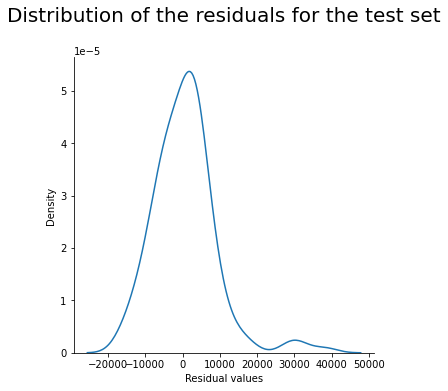

In [218]:

# Split our data for regression 
train, test = model_selection.train_test_split(groceries_income_ward, test_size=0.3)

# Select the parameters columns

columns = ['f_beer', 'f_dairy', 'f_fats_oils', 'f_fish', 'f_fruit_veg', 'f_grains',
           'f_meat_red', 'f_soft_drinks', 'f_spirits', 'f_sweets', 'f_tea_coffee', 'f_water']

# Build X and Y for the training set 
X_tr = train[columns]
y_tr = train['mean_income']

# Fit the model 
reg_rd = linear_model.LinearRegression().fit(X_tr, y_tr)

# Build X and Y for the test set
X_te = test[columns]
y_te = test['mean_income']

# Predict using our model and evaluate the R-squared score
y_pred = reg_rd.predict(X_te)
r2 = reg_rd.score(X_te, y_te)
print(f'R^2 score in the random split scenario : {r2}')

residual = y_te - y_pred
lm = sns.displot(residual,kind='kde')
plt.xlabel('Residual values')
plt.title('Distribution of the residuals for the test set', fontsize=20, y=1.1)
plt.show()

In [222]:
# Probability 
def CI_2_points_off(data, nbr_draws):
    """ Bootstrap confidence interval that our regression is off by more than 2 points"""
    percentage = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        percentage[n] = ((data_tmp <= -5000) | (5000 <= data_tmp)).sum() / len(data)
    
    return np.nanpercentile(percentage, 2.5), np.median(percentage), np.nanpercentile(percentage, 97.5)

lower, median, upper = CI_2_points_off(residual, 1000)
print(f'The probability that our prediction is off by more than 5000 pounds is : {median:.5}')
print(f'The confidence interval is : ({lower:.5}, {upper:.5})')

The probability that our prediction is off by more than 5000 pounds is : 0.44138
The confidence interval is : (0.36552, 0.52414)


### TODO 

- Try on area with representativeness > r 
- Confidence interval 

## Limitations : 

- We are using data for 2012/13 for income Data, even though we can deduce insights thanks to our assumption, having data from 2015 would've been better ! 